less is more - kaggle santander

# start

In [93]:
PRFX='0318_7'
trntmstmp=1584412344
valtmstmp=1584626395
import datetime
[datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)]

['2020-03-17 02:32:24', '2020-03-19 13:59:55']

# setup

In [94]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost
import dask_xgboost
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwing_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_follower_cnt',
'u2_following_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
cols_tgt2i = []

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [95]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [96]:
# dftrn=dd.read_csv(
#     f'{p_in}/trn_{trntmstmp}.tsv',
#     sep='\x01', header=None, names=cols,)

In [97]:
# ls -hlS $p_in | grep {trntmstmp} 

In [98]:
langs2use=['C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]
dftrn = dd.concat([dd.read_csv(f'{p_in}/trn_{lang}_{trntmstmp}.tsv',sep='\x01',header=None,names=cols) for lang in langs2use])

In [99]:
dftrn.head()

,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,...,u2id,u2_follower_cnt,u2_following_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,reply_tm,retwt_tm,retwt_cmmnt_tm,like_tm
0,101\t51747\t40843\t24666\t10531\t82796\t10731\...,NaN,AAAA980E498551AC33DDACDA232CFC69,Video,NaN,NaN,TopLevel,C7A400D9AD489ACF673CF12FBB80AAE5,1581169938,B0F96A3FFECC24F07B48FF1E463B41B9,...,0001576CAC09F044DC7E81D18DF93C90,3550,1901,False,1480527499,True,NaN,NaN,NaN,1.581170e+09
1,101\t10413\t10910\t10197\t131\t10803\t117\t143...,NaN,D38EF203C796635F5C6B7074D1404368,NaN,8930989006D12D8626675E26381C86E6,EAEAF41074EA9BD17A2B3B32280DEE57,TopLevel,C7A400D9AD489ACF673CF12FBB80AAE5,1581539773,CBA023B17294B22143947E9C5239164E,...,000594E59CE7CC686639B66B8C7BF19B,164,190,False,1319730588,False,NaN,NaN,NaN,NaN
2,101\t56898\t137\t10631\t11447\t30266\t10115\t1...,NaN,66D0357FA24606A4836386886687FBE1,Photo,NaN,NaN,Retweet,C7A400D9AD489ACF673CF12FBB80AAE5,1581124728,321083D445A3ADF1C1504F9D9EECB4CB,...,000614D083C9F0F0CE408647797AFFD8,60,710,False,1395443514,False,NaN,NaN,NaN,NaN
3,101\t246\t58588\t11216\t10160\t13386\t14854\t1...,NaN,BCF582EE337A943D451D94EDC8B551F6,Photo,NaN,NaN,TopLevel,C7A400D9AD489ACF673CF12FBB80AAE5,1581437007,8374207A681B710E15B0ACC2A4A1F1E9,...,0006BF2E04249FB9AC7546EAE2F01DAA,1065,253,False,1557103921,True,NaN,NaN,NaN,1.581451e+09
4,101\t20220\t30168\t10113\t106\t13026\t55886\t1...,NaN,E21DDD679656F8219283F51A220CD9B2,NaN,NaN,NaN,Quote,C7A400D9AD489ACF673CF12FBB80AAE5,1581025452,61144AFBB2F3DF59179F43787457B190,...,000A078A8F906CDC3812BD61AED37ED0,409,1859,False,1232187271,False,NaN,NaN,NaN,NaN


In [100]:
ys=~dftrn[cols_tgt_tmstmp].isna().astype('int8')+2

In [117]:
rows_new=[]
for step,row in dftrn.iterrows():
    if step%10000==0: print(dtnow(), i)
    rows_new.append(row)
#     for i,col in enumerate(cols_tgt_tmstmp):
#         if ~row[col].isna():
#             newrows.append(row)
    
    if step>1000: break

2020-03-19 14:25:45 17419


In [118]:
rows_new

[toks                101\t51747\t40843\t24666\t10531\t82796\t10731\...
 hshtgs                                                            NaN
 twtid                                AAAA980E498551AC33DDACDA232CFC69
 media                                                           Video
 links                                                             NaN
 domns                                                             NaN
 twttyp                                                       TopLevel
 lang                                 C7A400D9AD489ACF673CF12FBB80AAE5
 tm                                                         1581169938
 u1id                                 B0F96A3FFECC24F07B48FF1E463B41B9
 u1_fllwer_cnt                                                   20673
 u1_fllwing_cnt                                                    313
 u1_vrfed                                                        False
 u1_create_tm                                               1433530275
 u2id 

In [121]:
pd.DataFrame(rows_new)

,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,...,u2id,u2_follower_cnt,u2_following_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,reply_tm,retwt_tm,retwt_cmmnt_tm,like_tm
0,101\t51747\t40843\t24666\t10531\t82796\t10731\...,NaN,AAAA980E498551AC33DDACDA232CFC69,Video,NaN,NaN,TopLevel,C7A400D9AD489ACF673CF12FBB80AAE5,1581169938,B0F96A3FFECC24F07B48FF1E463B41B9,...,0001576CAC09F044DC7E81D18DF93C90,3550,1901,False,1480527499,True,NaN,NaN,NaN,1.581170e+09
1,101\t10413\t10910\t10197\t131\t10803\t117\t143...,NaN,D38EF203C796635F5C6B7074D1404368,NaN,8930989006D12D8626675E26381C86E6,EAEAF41074EA9BD17A2B3B32280DEE57,TopLevel,C7A400D9AD489ACF673CF12FBB80AAE5,1581539773,CBA023B17294B22143947E9C5239164E,...,000594E59CE7CC686639B66B8C7BF19B,164,190,False,1319730588,False,NaN,NaN,NaN,NaN
2,101\t56898\t137\t10631\t11447\t30266\t10115\t1...,NaN,66D0357FA24606A4836386886687FBE1,Photo,NaN,NaN,Retweet,C7A400D9AD489ACF673CF12FBB80AAE5,1581124728,321083D445A3ADF1C1504F9D9EECB4CB,...,000614D083C9F0F0CE408647797AFFD8,60,710,False,1395443514,False,NaN,NaN,NaN,NaN
3,101\t246\t58588\t11216\t10160\t13386\t14854\t1...,NaN,BCF582EE337A943D451D94EDC8B551F6,Photo,NaN,NaN,TopLevel,C7A400D9AD489ACF673CF12FBB80AAE5,1581437007,8374207A681B710E15B0ACC2A4A1F1E9,...,0006BF2E04249FB9AC7546EAE2F01DAA,1065,253,False,1557103921,True,NaN,NaN,NaN,1.581451e+09
4,101\t20220\t30168\t10113\t106\t13026\t55886\t1...,NaN,E21DDD679656F8219283F51A220CD9B2,NaN,NaN,NaN,Quote,C7A400D9AD489ACF673CF12FBB80AAE5,1581025452,61144AFBB2F3DF59179F43787457B190,...,000A078A8F906CDC3812BD61AED37ED0,409,1859,False,1232187271,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,101\t56898\t137\t23859\t10147\t35794\t11129\t1...,NaN,D2EC5F9BD68FB4E28D056B81395F9381,Video,NaN,NaN,Retweet,C7A400D9AD489ACF673CF12FBB80AAE5,1580957389,F3ED708727081938ED7BC5AA0AB9E701,...,1D8F17F2718CAAB6712DCE10F95A9DD2,16,109,False,1463218726,False,NaN,NaN,NaN,NaN
998,101\t37312\t100\t14120\t131\t120\t120\t188\t11...,NaN,89C54F5139122FA445A6E245C53C4775,Photo,NaN,NaN,TopLevel,C7A400D9AD489ACF673CF12FBB80AAE5,1581446688,347E6EE254B080C44AA11F5FF5092AF8,...,1D9BAD6F2D1B742FD2D02FD71D628645,9,343,False,1513426535,False,NaN,NaN,NaN,1.581448e+09
999,101\t56898\t137\t32470\t10874\t76797\t52064\t1...,NaN,779A4B0908645928A907A6848E7FF090,NaN,NaN,NaN,Retweet,C7A400D9AD489ACF673CF12FBB80AAE5,1581456792,90D21C40D1D507704F01E28F2B0A6AF2,...,1DABFAB3D131CA3D603FAFB3E5F05D84,435,309,False,1386090240,True,NaN,NaN,NaN,NaN
1000,101\t56898\t137\t10173\t18599\t10157\t10418\t1...,NaN,677747771FD4452F6F412D63F4446F4B,Photo\tPhoto,NaN,NaN,Retweet,C7A400D9AD489ACF673CF12FBB80AAE5,1581034288,E0741C05B00759347D24D8F0FCA301D2,...,1DB08CD5AB5643CE73EFF4CD1CADB3E9,305,491,False,1426731255,False,NaN,NaN,NaN,NaN


In [111]:
newrows=[]
for step,row in dftrn.iterrows():
    if step%10000==0: print(dtnow(), i)
    for i,col in enumerate(cols_tgt_tmstmp):
        if ~row[col].isna():
            newrows.append(row)
    
    if i>1000: break

SyntaxError: invalid syntax (<ipython-input-111-9fa089370dd7>, line 4)

In [108]:
row

toks                101\t51747\t40843\t24666\t10531\t82796\t10731\...
hshtgs                                                            NaN
twtid                                AAAA980E498551AC33DDACDA232CFC69
media                                                           Video
links                                                             NaN
domns                                                             NaN
twttyp                                                       TopLevel
lang                                 C7A400D9AD489ACF673CF12FBB80AAE5
tm                                                         1581169938
u1id                                 B0F96A3FFECC24F07B48FF1E463B41B9
u1_fllwer_cnt                                                   20673
u1_fllwing_cnt                                                    313
u1_vrfed                                                        False
u1_create_tm                                               1433530275
u2id                

In [81]:
df=dftrn

In [ ]:
df['len_toks']=df.toks.apply(len, meta=('toks', 'int64'))
for media in ['Photo', 'Video', 'GIF']:
    df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x, 
                                                                 meta=('media', 'string'))
for col in ['hshtgs', 'links', 'domns',]:
    df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
                                                      meta=(col, 'string'))
df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

In [82]:
for typ in twttyps:
    df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')
# df[['twttyp']+[f'twttyp_{typ}' for typ in twttyps]].head()

,twttyp,twttyp_TopLevel,twttyp_Retweet,twttyp_Quote
0,TopLevel,1,0,0
1,TopLevel,1,0,0
2,Retweet,0,1,0
3,TopLevel,1,0,0
4,Quote,0,0,1


In [ ]:
for lang in langs:
    df[f'lang_{lang}']=(df.lang==lang).astype('int8')
# pd.options.display.max_rows = 999
# df[['lang']+[f'lang_{lang}' for lang in langs]].head().T

In [92]:
df.head()

,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,...,lang_BF477808A37E3E4E9C5D9F1839E8519E,lang_97F81BD92A1ACA3F1F43C154E689350F,lang_60A3DB168094D41241E45E0DE3539BC0,lang_12D8CEB94F89D11D7EB95EAE9689B009,lang_F73266A79468BB89C4325FDEDB0B533C,lang_4690215948DBF6872B8ED1C2BC87B17E,lang_D18801336202297E6484F634CAC6592E,lang_2E18F6F53E3CF073911AF0A93BBE5373,lang_B2235C8B73239FDC5780DD132419833A,lang_515E873C86EE1577E75FA2387B7FA59E
0,101\t51747\t40843\t24666\t10531\t82796\t10731\...,NaN,AAAA980E498551AC33DDACDA232CFC69,Video,NaN,NaN,TopLevel,C7A400D9AD489ACF673CF12FBB80AAE5,1581169938,B0F96A3FFECC24F07B48FF1E463B41B9,...,0,0,0,0,0,0,0,0,0,0
1,101\t10413\t10910\t10197\t131\t10803\t117\t143...,NaN,D38EF203C796635F5C6B7074D1404368,NaN,8930989006D12D8626675E26381C86E6,EAEAF41074EA9BD17A2B3B32280DEE57,TopLevel,C7A400D9AD489ACF673CF12FBB80AAE5,1581539773,CBA023B17294B22143947E9C5239164E,...,0,0,0,0,0,0,0,0,0,0
2,101\t56898\t137\t10631\t11447\t30266\t10115\t1...,NaN,66D0357FA24606A4836386886687FBE1,Photo,NaN,NaN,Retweet,C7A400D9AD489ACF673CF12FBB80AAE5,1581124728,321083D445A3ADF1C1504F9D9EECB4CB,...,0,0,0,0,0,0,0,0,0,0
3,101\t246\t58588\t11216\t10160\t13386\t14854\t1...,NaN,BCF582EE337A943D451D94EDC8B551F6,Photo,NaN,NaN,TopLevel,C7A400D9AD489ACF673CF12FBB80AAE5,1581437007,8374207A681B710E15B0ACC2A4A1F1E9,...,0,0,0,0,0,0,0,0,0,0
4,101\t20220\t30168\t10113\t106\t13026\t55886\t1...,NaN,E21DDD679656F8219283F51A220CD9B2,NaN,NaN,NaN,Quote,C7A400D9AD489ACF673CF12FBB80AAE5,1581025452,61144AFBB2F3DF59179F43787457B190,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def prep(df, isval=True):
    df['len_toks']=df.toks.apply(len, meta=('toks', 'int64'))
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x, 
                                                                     meta=('media', 'string'))
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
                                                          meta=(col, 'string'))
    for typ in ['TopLevel','Retweet','Quote']:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm
    
    if isval: return df
    
    df[cols_tgt]=~df[cols_tgt_tmstmp].isna().astype('int8')+2
    return df

# old

In [5]:
%%time
# https://stackoverflow.com/questions/40376425/dask-dataframe-equivalent-of-pandas-dataframe-sort-values
lendf = df.shape[0].compute()
valsz = int(lendf*0.15)
trnsz = lendf-valsz
lendf, trnsz, valsz

CPU times: user 6min 3s, sys: 40.7 s, total: 6min 44s
Wall time: 2min 50s


(23652265, 20104426, 3547839)

In [30]:
%%time
dftr=df.nsmallest(trnsz,'tm')
dfvl=df.nlargest(valsz,'tm')

# assert dfvl.tm.min().compute() >= dftr.tm.max().compute()

CPU times: user 5.22 ms, sys: 8.77 ms, total: 14 ms
Wall time: 13.3 ms


In [31]:
dftr.columns

Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'reply_tm', 'retwt_tm',
       'retwt_cmmnt_tm', 'like_tm', 'len_toks', 'has_media_Photo',
       'has_media_Video', 'has_media_GIF', 'num_hshtgs', 'num_links',
       'num_domns', 'twttyp_TopLevel', 'twttyp_Retweet', 'twttyp_Quote',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'reply', 'retwt',
       'retwt_cmmnt', 'like'],
      dtype='object')

In [32]:
cols_feat=[
       'tm', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'len_toks', 'has_media_Photo',
       'has_media_Video', 'has_media_GIF', 'num_hshtgs', 'num_links',
       'num_domns', 'twttyp_TopLevel', 'twttyp_Retweet', 'twttyp_Quote',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2',
]

In [33]:
%%time
X, ys = (df[cols].to_dask_array(lengths=True) for cols in (cols_feat,cols_tgt))

CPU times: user 18.6 s, sys: 2.64 s, total: 21.2 s
Wall time: 4min 9s


In [34]:
%%time
Xtrn, Xval, ystrn, ysval = train_test_split(X, ys, test_size=0.15, random_state=SEED)

CPU times: user 1.64 s, sys: 18.7 ms, total: 1.65 s
Wall time: 1.62 s


# train

In [35]:
client = Client()

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [36]:
tgt2params = {
        'Retweet': {
            'objective': 'binary:logistic',
#             'max_depth':5,
#             'min_child_weight':2,
#             'gamma':1,
        }, 
        'Reply': {
            'objective': 'binary:logistic',
#             'max_depth':5,
#             'min_child_weight':2,
            'gamma':1,
        }, 
        'Like': {
            'objective': 'binary:logistic',
#             'max_depth':5,
#             'min_child_weight':2,
#             'gamma':1,
        }, 
        'RTwCmnt': {
            'objective': 'binary:logistic',
#             'max_depth':5,
#             'min_child_weight':2,
#             'gamma':1,
        }, 
}

In [37]:
tgt2bst={}
tgt2col2fscr={}
for i,tgt in enumerate(tgts):
    params = tgt2params[tgt]
    bst = dask_xgboost.train(client, params,
                             Xtrn, ystrn[:,i],
                             num_boost_round=10)
    tgt2bst[tgt]=bst
    print(dtnow(), tgt)
    
    fi2col=dict(zip(bst.feature_names, cols_feat))
    col2fi=dict(zip(cols_feat, bst.feature_names))
    fi2fscr=bst.get_fscore()
    col2fscr={col:fi2fscr.get(fi,0) for col,fi in col2fi.items()}
    tgt2col2fscr[tgt]=col2fscr

pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-18 22:17:43 Retweet
2020-03-18 22:26:12 Reply
2020-03-18 22:34:23 Like
2020-03-18 22:42:25 RTwCmnt


In [38]:
tgt2bst=pickle.load(open(f"{p_out}/tgt2bst.p", "rb"))

Retweet


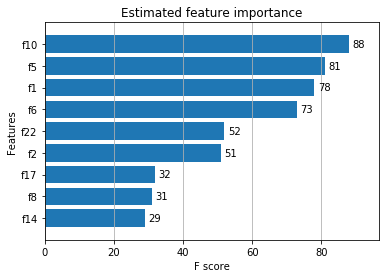

,0,1
10,len_toks,88
5,u2_follower_cnt,81
1,u1_fllwer_cnt,78
6,u2_following_cnt,73
22,tmdlta_twtu2,52
2,u1_fllwing_cnt,51
17,twttyp_TopLevel,32
8,u2_create_tm,31
14,num_hshtgs,29
18,twttyp_Retweet,23


Reply


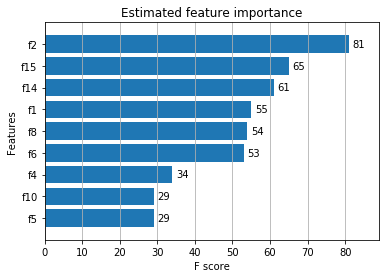

,0,1
2,u1_fllwing_cnt,81
15,num_links,65
14,num_hshtgs,61
1,u1_fllwer_cnt,55
8,u2_create_tm,54
6,u2_following_cnt,53
4,u1_create_tm,34
5,u2_follower_cnt,29
10,len_toks,29
22,tmdlta_twtu2,22


Like


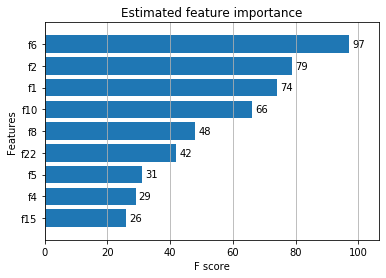

,0,1
6,u2_following_cnt,97
2,u1_fllwing_cnt,79
1,u1_fllwer_cnt,74
10,len_toks,66
8,u2_create_tm,48
22,tmdlta_twtu2,42
5,u2_follower_cnt,31
4,u1_create_tm,29
15,num_links,26
14,num_hshtgs,25


RTwCmnt


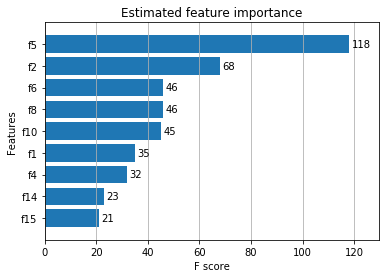

,0,1
5,u2_follower_cnt,118
2,u1_fllwing_cnt,68
6,u2_following_cnt,46
8,u2_create_tm,46
10,len_toks,45
1,u1_fllwer_cnt,35
4,u1_create_tm,32
14,num_hshtgs,23
15,num_links,21
22,tmdlta_twtu2,20


In [39]:
def show_feat_importance(bst):
    ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()

for i,tgt in enumerate(tgts):
    print(tgt)
    show_feat_importance(tgt2bst[tgt])
    col2fscr=tgt2col2fscr[tgt]
    display(pd.DataFrame(col2fscr.items()).sort_values(1, ascending=False))

# validate

In [40]:
tgt2ytrn={}
tgt2yval={}
tgt2prdtrn={}
tgt2prdval={}
for i,tgt in enumerate(tgts):
    print(dtnow(), tgt)
    prdtrn = dask_xgboost.predict(client, tgt2bst[tgt], Xtrn).persist()
    prdval = dask_xgboost.predict(client, tgt2bst[tgt], Xval).persist()
    ytrn, prdtrn = dask.compute(ystrn[:,i], prdtrn)
    yval, prdval = dask.compute(ysval[:,i], prdval)
    tgt2ytrn[tgt],tgt2yval[tgt]=ytrn,yval
    tgt2prdtrn[tgt],tgt2prdval[tgt]=prdtrn,prdval

2020-03-18 22:42:27 Retweet
2020-03-18 22:46:39 Reply
2020-03-18 22:50:51 Like
2020-03-18 22:55:02 RTwCmnt


In [41]:
def show_roc_auc(prd,y):
    fpr, tpr, _ = roc_curve(y,prd)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, lw=3,
            label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title="ROC Curve",
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    ax.legend();
    plt.show()

In [42]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for i,tgt in enumerate(tgts):
    print(tgt)
    ytrn,yval = tgt2ytrn[tgt],tgt2yval[tgt]
    prdtrn,prdval = tgt2prdtrn[tgt],tgt2prdval[tgt]
    scr_rocauc_trn = roc_auc_score(ytrn, prdtrn)
    scr_rocauc_val = roc_auc_score(yval, prdval)
    scr_auc_trn=compute_prauc(prdtrn, ytrn)
    scr_rce_trn=compute_rce(prdtrn, ytrn)
    scr_auc_val=compute_prauc(prdval, yval)
    scr_rce_val=compute_rce(prdval, yval)
    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.7212 valid auc: 0.7199
train prauc: 0.2199 valid auc: 0.2173
train rce: 8.0586 valid rce: 7.9373
Reply
train rocauc: 0.7670 valid auc: 0.7661
train prauc: 0.0809 valid auc: 0.0800
train rce: 4.3325 valid rce: 4.1404
Like
train rocauc: 0.7220 valid auc: 0.7217
train prauc: 0.6895 valid auc: 0.6894
train rce: 11.1452 valid rce: 11.1157
RTwCmnt
train rocauc: 0.6624 valid auc: 0.6620
train prauc: 0.0081 valid auc: 0.0076
train rce: -62.1275 valid rce: -63.3644


In [43]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']

In [44]:
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.219875,8.05862,0.0808666,4.3325,0.689511,11.1452,0.00809761,-62.1275
scrval,0.217308,7.93728,0.0800309,4.1404,0.689355,11.1157,0.00760598,-63.3644


# infer

In [ ]:
PRFX_PRP_TST = 'prep0318_2' 
valtmstmp=

In [21]:
ls {p_prp} | grep {valtmstmp}

dfval_12D8CEB94F89D11D7EB95EAE9689B009_1584405047__prep0318_1.tsv
dfval_1584405047__prep0318_1.tsv
dfval_1BC639981AE88E09129594B11F894A21_1584405047__prep0318_1.tsv
dfval_2216D01F7B48554E4211021A46816FCF_1584405047__prep0318_1.tsv
dfval_22C448FF81263D4BAF2A176145EE9EAD_1584405047__prep0318_1.tsv
dfval_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047__prep0318_1.tsv
dfval_2E18F6F53E3CF073911AF0A93BBE5373_1584405047__prep0318_1.tsv
dfval_3121F7240D488F74EEED9312E174B217_1584405047__prep0318_1.tsv
dfval_3A85BCEC571C3F5AB1069E4924189177_1584405047__prep0318_1.tsv
dfval_4690215948DBF6872B8ED1C2BC87B17E_1584405047__prep0318_1.tsv
dfval_515E873C86EE1577E75FA2387B7FA59E_1584405047__prep0318_1.tsv
dfval_54208B51D44E7D91DC2F3DD02ADEDEC2_1584405047__prep0318_1.tsv
dfval_544FA32458C903F1125FE6598300A047_1584405047__prep0318_1.tsv
dfval_57ADD4576E2AD6648E9B2DE32F3462A5_1584405047__prep0318_1.tsv
dfval_60A3DB168094D41241E45E0DE3539BC0_1584405047__prep0318_1.tsv
dfval_6431A618DCF7F4CB7F62A95A39BAB77A_1584

In [22]:
dftst=dd.read_csv(
    f'{p_prp}/dfval_{valtmstmp}__{PRFX_PRP_TST}.tsv',
    sep='\x01',
    encoding='utf8')

In [23]:
Xtst = dftst[cols_feat].to_dask_array(lengths=True)

In [24]:
%%time
tgt2prdtst={}
for i,tgt in enumerate(tgts):
    prdtst = dask_xgboost.predict(client, tgt2bst[tgt], Xtst)
    prdtst = prdtst
    tgt2prdtst[tgt]=prdtst 

CPU times: user 7.96 ms, sys: 0 ns, total: 7.96 ms
Wall time: 5.9 ms


In [25]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [26]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False,single_file=True)

2020-03-18 21:57:01 Retweet
2020-03-18 21:59:09 Reply
2020-03-18 22:01:18 Like
2020-03-18 22:03:28 RTwCmnt
CPU times: user 34.9 s, sys: 4.99 s, total: 39.9 s
Wall time: 8min 40s


In [27]:
# %%time
# for tgt in tgts:
#     print(dtnow(), tgt)
#     dfsub = pd.concat(pd.read_csv(o, header=None) for o in sorted(glob.glob(f'{p_out}/{tgt}__{PRFX}_*.csv')))
#     dfsub.to_csv(f'{p_out}/{tgt}__{PRFX}.csv', 
#                           index=False, 
#                           header=False)

In [28]:
!head -n 2 {p_prp}/val_{valtmstmp}.tsv

head: cannot open ‘/data/git/recsys20/output/prep0318_1/val_1584405047.tsv’ for reading: No such file or directory


In [29]:
for tgt in tgts:
    !head -n 2 {p_out}/{tgt}__{valtmstmp}__{PRFX}.csv

7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB,0.07791518
CCBFBA5AFE7EFC03102EA8D0F86C4208,00000776B07587ECA9717BFC301F2D6E,0.09037872
7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB,0.076144606
CCBFBA5AFE7EFC03102EA8D0F86C4208,00000776B07587ECA9717BFC301F2D6E,0.034474615
7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB,0.51611364
CCBFBA5AFE7EFC03102EA8D0F86C4208,00000776B07587ECA9717BFC301F2D6E,0.32663488
7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB,0.024150688
CCBFBA5AFE7EFC03102EA8D0F86C4208,00000776B07587ECA9717BFC301F2D6E,0.024838887
